# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Joost Jaspers"
STUDENT_1_STUDENT_NUMBER = "5372925"
STUDENT_1_NETID = "jhfjaspers"
STUDENT_1_EMAIL = "J.H.F.Jaspers@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 2a.4 - PD+ (2p)

**Author:** Maximilian Stölzle

**For inquiries, contact:** Jingyue Liu (J.Liu-14@tudelft.nl)

In this task, you will implement a PD+ controller. The controller consists of the feedforward term

\begin{equation}
\tau_\mathrm{ff} = M(\theta) \: \ddot{\theta}^\mathrm{d} + C(\theta, \dot{\theta}) \: \dot{\theta}^\mathrm{d} + G(\theta),
\end{equation}

and the PD feedback term

\begin{equation}
\tau_\mathrm{fb} = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta}).
\end{equation}

We emphasize the similarity in structure of the control law with respect to _PD + feedforward_ from task 2a.3. However, the dynamical matrices (i.e. $M$, $C$, and $G$) are now evaluated at the current robot state instead of along the trajectory.

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
import jax

jax.config.update("jax_platforms", "cpu")  # set default device to 'cpu'
jax.config.update("jax_enable_x64", True)  # double precision
from jax import numpy as jnp
import os
from pathlib import Path

from jax_double_pendulum.dynamics import dynamical_matrices
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

## Derivation of the closed-loop system dynamics (1p)

Please derive the closed-loop dynamics by substituting the control law into the equations of motion. Which equation is correct?

**A.** $M(\theta) \: \ddot{\theta} + C(\theta, \dot{\theta}) \: \dot{\theta} + G(\theta) = M(\theta^\mathrm{d}) \: \ddot{\theta}^\mathrm{d} + C(\theta^\mathrm{d}, \dot{\theta}^\mathrm{d}) \: \dot{\theta}^\mathrm{d} + G(\theta^\mathrm{d}) + k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})$

**B.**  $M(\theta^\mathrm{d}) \: (\ddot{\theta}^\mathrm{d} - \ddot{\theta}) + C(\theta^\mathrm{d}, \dot{\theta}^\mathrm{d}) \: (\dot{\theta}^\mathrm{d} - \dot{\theta}) = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})$

**C.** $M(\theta) \: (\ddot{\theta} - \ddot{\theta}^\mathrm{d}) + C(\theta, \dot{\theta}) \: (\dot{\theta} - \dot{\theta}^\mathrm{d}) = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})$

**D.** $M(\theta) \: (\ddot{\theta}^\mathrm{d} - \ddot{\theta}) + C(\theta, \dot{\theta}) \: (\dot{\theta}^\mathrm{d} - \dot{\theta}) = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})$

In [4]:
# please write the answer ("A", "B", "C", or "D") into the `answer_1` variable
answer_1 = None

# YOUR CODE HERE
answer_1 = "D"

In [5]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_1 in ["A", "B", "C", "D"], 'Please answer "A", "B", "C", or "D"'


## Implementing `ctrl_ff_pd_plus` (0.5p)
Please implement a feedforward term of the PD+ controller into the function `ctrl_ff_pd_plus` in the notebook `controllers.ipynb`.
You can use `M, C, G = dynamical_matrices_fn(.)` to access the components of the equations of motion.

In [6]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import PD feedback and PD+ controllers from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd, ctrl_ff_pd_plus

# construct feedforward controller
ctrl_ff = partial(ctrl_ff_pd_plus, partial(dynamical_matrices, ROBOT_PARAMS))

# test output shape of ctr_ff_pd_plus
_th, _th_d = jnp.ones((2,)), jnp.ones((2,))
_th_des, _th_d_des, _th_dd_des = jnp.ones((2,)), jnp.ones((2,)), jnp.ones((2,))
_tau_dummy = ctrl_ff(_th, _th_d, _th_des, _th_d_des, _th_dd_des)
print("Computed torque:", _tau_dummy, "Nm")
assert _tau_dummy.shape == (2,), "The computed torque needs to be of shape (2, )"


Computed torque: [159.60804365  25.40109686] Nm


## Simulating the closed-loop system (0.5p)

Please simulate the closed-loop system using a PD+ controller for regulating the system to follow the given ellipse trajectory. You can use the notebook from Task 2a.1 as an inspiration. You don't need to tune the feedback gains yourself as they are already set to $k_\mathrm{p} = \mathrm{diag}(500, 500)$ and $k_\mathrm{d} = \mathrm{diag}(50, 50)$.

In [7]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# initial link angles (i.e. at the first time-step)
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

# controller parameters
# define the proportional gain matrix kp and the derivative gain matrix kd
kp = 500 * jnp.eye(2)  # [Nm/rad]
kd = 50 * jnp.eye(2)  # [Nm s/rad]

In [10]:
# simulate the robot with the given controller
# save the simulation date in `sim_ts`

# YOUR CODE HERE
sim_ts = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_ff=ctrl_ff,
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
)

# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.022 0.019] rad, RMSE theta_d: [0.074 0.146] rad/s, RMSE theta_dd: [0.268 1.797] rad/s^2
RMSE x: 0.0491 m, RMSE x_d: 0.232 m/s, RMSE x_dd: 2.03 m/s^2


In [11]:
# DO NOT REMOVE OR MODIFY THIS CELL

rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
print("Euclidean norm of RMSE x:", "{:.5f}".format(jnp.linalg.norm(rmse_x)), "m")

assert jnp.allclose(
    kp, 500 * jnp.eye(2), rtol=RTOL, atol=ATOL
), "You are not allowed to change the proportional gains. Please leave them at 500."
assert jnp.allclose(
    kd, 50 * jnp.eye(2), rtol=RTOL, atol=ATOL
), "You are not allowed to change the derivative gains. Please leave them at 50."

assert (
    jnp.linalg.norm(rmse_x) < 0.06
), "With a correct implementation of the controller, the end-effector position should be smaller than 0.06m."

Euclidean norm of RMSE x: 0.04909 m


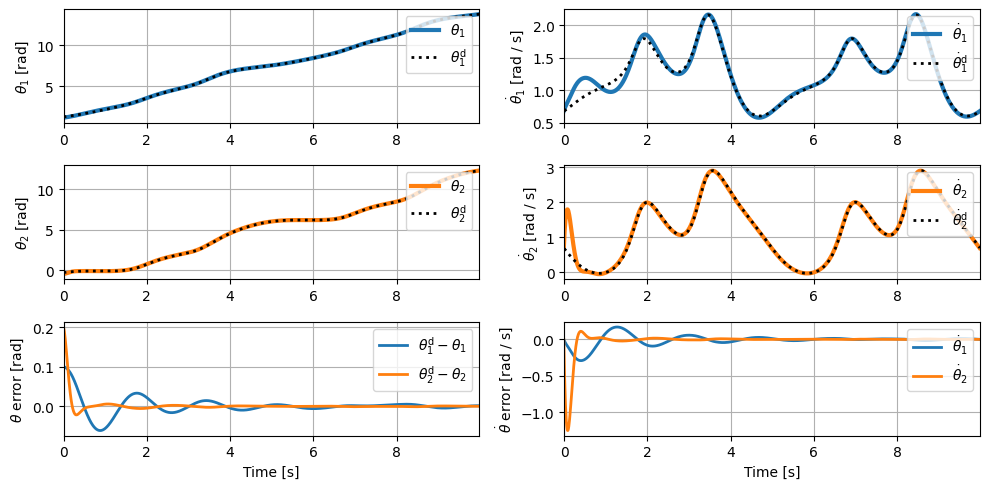

In [12]:
# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(
        outputs_dir / "task_2a-4_configuration_space_trajectory_following.pdf"
    ),
)

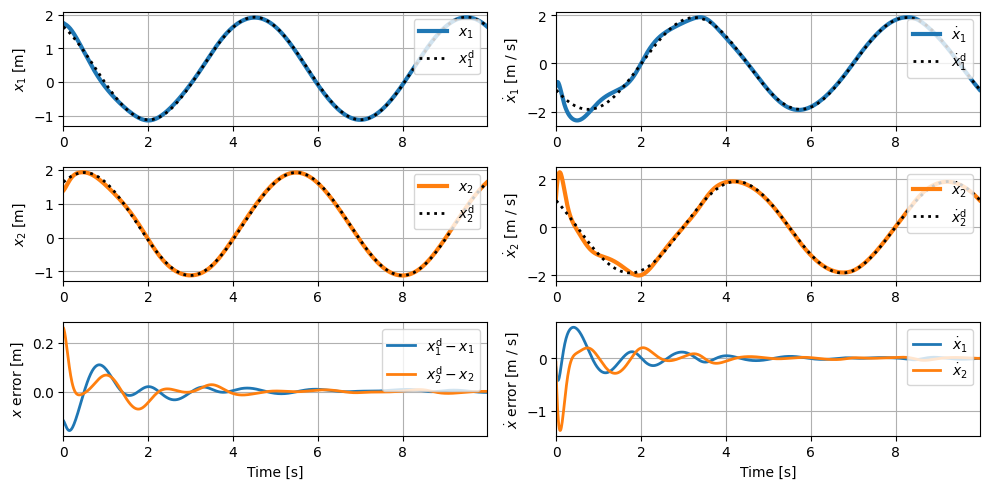

In [13]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(outputs_dir / "task_2a-4_operational_space_trajectory_following.pdf"),
)

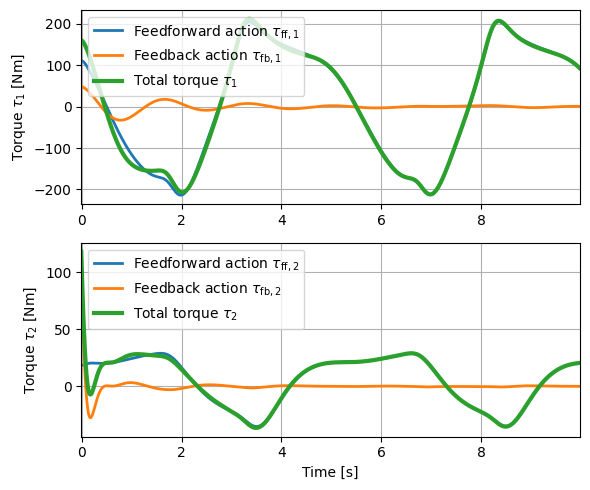

In [14]:
# plot the actuation sequence
plot_actuation(sim_ts, filepath=str(outputs_dir / "task_2a-4_actuation.pdf"))

In [15]:
if not AUTOGRADING:
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2a-4_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))